In [1]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
import math
from scipy import stats
import h5py
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import pandas as pd


*IMPORTANT: PLEASE READ THE REPORT BEFORE GOING OVER THE CODE*

**Data Preprocessing**

In [2]:
#import cropped data
import cv2
import os, random
path= ['CroppedYale/yaleB'+s  for s in ["%.2d" % i for i in range(40)]]
del path[0]
del path[13]
cropped=[]
label=[]
count_file=[]
for k,j in enumerate(path):
    fileList = os.listdir(j)
    count_file.append(len(fileList))
    for file in fileList:
        d=cv2.imread(j+'/'+file,-1).flatten()
        cropped.append(d)
        label.append(k)

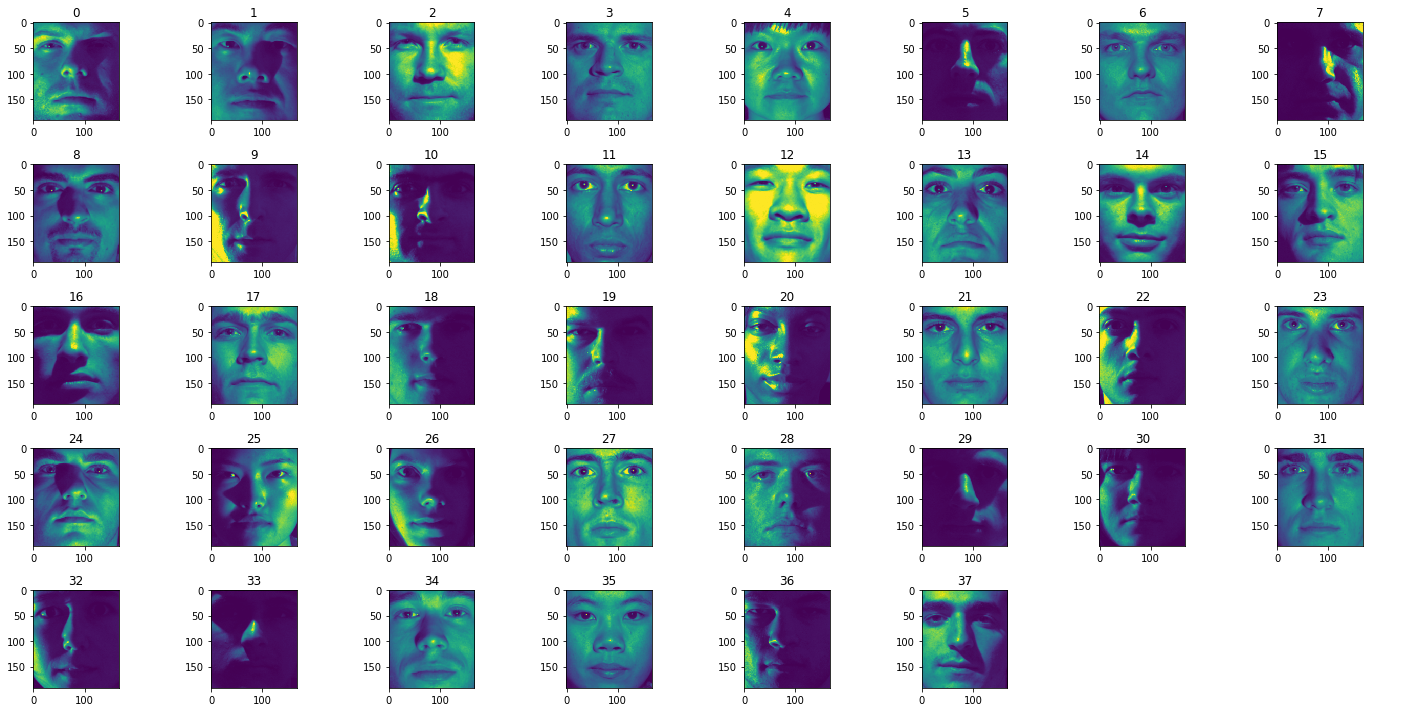

In [54]:
#visualizd portraits and identify gender
fig,axs = plt.subplots(5,8,figsize=(20, 10), facecolor='w', edgecolor='k')
axs = axs.ravel()
for k,j in enumerate(path):
    p=random.choice(os.listdir(j))
    s=cv2.imread(j+'/'+p,-1)
    axs[k].imshow(s)
    axs[k].set_title(k)
axs[38].set_axis_off()
axs[39].set_axis_off()
fig.tight_layout()

In [ ]:
#create gender label
gender=np.ones(38)
female=np.array([4,16,20,25,26,30,32,35])
gender[female]=0
import itertools as it
glabel=[c for n, m in zip(gender, count_file) for c in it.repeat(n, m)]
glabel=np.array(glabel)

In [5]:
cropped=np.array(cropped) #for following classification tasks
cropped_svd=np.transpose(cropped) #for following singular value decomposition tasks

In [65]:
#unzip the uncropped data tar file
import tarfile

uncropped_p = tarfile.open('yalefaces_uncropped.tar')
uncropped_p.extractall('./uncropped')
uncropped_p.close()

In [7]:
#load the uncropped data 
from PIL import Image
import glob
org_dataset = []
for i in range(1, 16):
    filelist = glob.glob('./uncropped/yalefaces/subject'+str(i).zfill(2)+"*")
    for fname in filelist:
        img = np.array(Image.open(fname)).flatten() #transform a 2D picture to 1D
        org_dataset.append(img)
uncropped = np.array(org_dataset) #for following classification tasks

In [8]:
uncropped_svd=np.transpose(uncropped) #for following singular value decomposition tasks

## Singular Value Decomposition

**Single Value Decomposition of Cropped Images**

In [16]:
uc, sc, vc = np.linalg.svd(cropped_svd, full_matrices=0)

In [27]:
sc_per=sc/sum(sc) #compute the energy of each eigenvectors
sc_per[sc_per>0.001].shape #find the number of leading eigenvectors with threshold 0.001

(161,)

In [28]:
np.sum(sc_per[sc_per>0.001]) #total energy of the leading eigenvectors

0.5845064268049819

**Single Value Decomposition of Uncropped Images**

In [29]:
uuc, suc, vuc = np.linalg.svd(uncropped_svd, full_matrices=0)

In [30]:
suc_per=suc/sum(suc) #compute the energy of each eigenvectors
suc_per[suc_per>0.001].shape

(150,)

In [33]:
np.sum(suc_per[suc_per>0.001]) #find the number of leading eigenvectors with threshold 0.001

0.9955267492581631

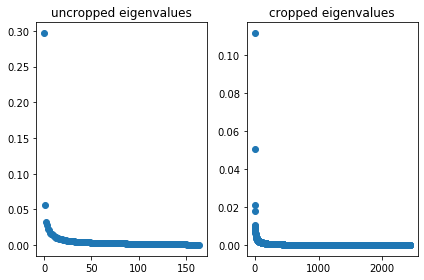

In [48]:
fig,(ax1,ax2)=plt.subplots(1,2)
ax1.plot(suc_per.reshape(-1,1),'o')
ax1.set_title('uncropped eigenvalues')
ax2.plot(sc_per.reshape(-1,1),'o')
ax2.set_title('cropped eigenvalues')
fig.tight_layout()
fig.savefig('eigenvalues.jpg')

**Principal Component Analysis**

In [10]:
#normalize the cropped data
from sklearn.preprocessing import normalize
X=normalize(cropped)

In [11]:
#perform principal component analysis and get principal components X_pca
from sklearn.decomposition import PCA
n_components = 160
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X)
X_pca=pca.transform(X)

## Face Recognition
- Naive Bayes
- Suport Vector Machines
- Extreme Gradient Boosting (XG Boost)
- Random Forest

**Naive Bayes**

In [31]:
from sklearn.naive_bayes import GaussianNB
kf = KFold(n_splits=5, shuffle = True) #5-fold cross validation with data shuffles
nb = GaussianNB()
nb_a= cross_val_score(nb, X_pca, label , cv=kf) 
nb_f1= cross_val_score(nb, X_pca, label , cv=kf, scoring='f1_micro')

In [32]:
print('The average accuracy score of Naive Bayes is',np.mean(nb_a),'The average F-1 score of Naive Bayes is',np.mean(nb_f1))

The average accuracy score of Naive Bayes is 0.813409553747222 The average F-1 score of Naive Bayes is 0.8129912709880767


**Suport Vector Machines**

In [25]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
svm_a= cross_val_score(svm, X_pca, label, cv=kf) 
svm_f1= cross_val_score(svm, X_pca, label, cv=kf, scoring='f1_micro')

In [28]:
print('The average accuracy score of SVM is',np.mean(svm_a),'The average F-1 score of SVM is',np.mean(svm_f1))

The average accuracy score of SVM is 0.9198519532537329 The average F-1 score of SVM is 0.9210915912490176


**XG Boost**

In [41]:
import xgboost
xg = xgboost.XGBClassifier()
xg_a= cross_val_score(xg, X_pca, label, cv=kf) 
xg_f1= cross_val_score(xg, X_pca, label, cv=kf, scoring='f1_micro')

In [42]:
print('The average accuracy score of XG Boost is',np.mean(xg_a),'The average F-1 score of XG Boost is',np.mean(xg_f1))

The average accuracy score of XG Boost is 0.8553189511665442 The average F-1 score of XG Boost is 0.8635494038414413


**Random Forest**

In [38]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_a= cross_val_score(rf, X_pca, label, cv=kf) 
rf_f1= cross_val_score(rf, X_pca, label, cv=kf, scoring='f1_micro')

In [39]:
print('The average accuracy score of Random Forest is',np.mean(rf_a),'The average F-1 score of Random Forest is',np.mean(rf_f1))

The average accuracy score of Random Forest is 0.9099889302946569 The average F-1 score of Random Forest is 0.9042309934849293


## Gender Recognition
- Logistic Regression
- Random Forest
- Support Vector Machines
- Linear Discriminant Analysis
- Naive Bayes

**Logistic Regression**

In [13]:
kf = KFold(n_splits=5, shuffle = True) #5-fold cross validation
from sklearn.linear_model import LogisticRegression
lg=LogisticRegression()
lg_a= cross_val_score(lg, X_pca, glabel, cv=kf) 
lg_f1= cross_val_score(lg, X_pca, glabel, cv=kf, scoring='f1')

In [33]:
print('The average accuracy score of Logistic Regression is',np.mean(lg_a),'The average F-1 score of Logistic Regression is',np.mean(lg_f1))

The average accuracy score of Logistic Regression is 0.9675294276708832 The average F-1 score of Logistic Regression is 0.9781593846362977


**Random Forest**

In [36]:
from sklearn.ensemble import RandomForestClassifier
rfg = RandomForestClassifier()
rfg_a= cross_val_score(rfg, X_pca, glabel, cv=kf) 
rfg_f1= cross_val_score(rfg, X_pca, glabel, cv=kf, scoring='f1_micro')

In [37]:
print('The average accuracy score of Random Forest is',np.mean(rfg_a),'The average F-1 score of Random Forest is',np.mean(rfg_f1))

The average accuracy score of Random Forest is 0.9412291598009144 The average F-1 score of Random Forest is 0.9449244133478676


**Suport Vector Machines**

In [38]:
from sklearn.svm import SVC
svmg = SVC(kernel='rbf')
svmg_a= cross_val_score(svmg, X_pca, glabel, cv=kf) 
svmg_f1= cross_val_score(svmg, X_pca, glabel, cv=kf, scoring='f1_micro')

In [39]:
print('The average accuracy score of SVM is',np.mean(svmg_a),'The average F-1 score of SVM is',np.mean(svmg_f1))

The average accuracy score of SVM is 0.9646496142503442 The average F-1 score of SVM is 0.9650645169467893


**Linear Discriminant Analysis**

In [52]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda= LinearDiscriminantAnalysis()
lda_a= cross_val_score(lda, X_pca, glabel, cv=kf) 
lda_f1= cross_val_score(lda, X_pca, glabel, cv=kf, scoring='f1_micro')

In [53]:
print('The average accuracy score of Linear Discriminant Analysis is',np.mean(lda_a),'The average F-1 score of Linear Discriminant Analysis is',np.mean(lda_f1))

The average accuracy score of Linear Discriminant Analysis is 0.9613625032744357 The average F-1 score of Linear Discriminant Analysis is 0.9613650383214608


**Naive Bayes**

In [14]:
from sklearn.naive_bayes import GaussianNB
nbg = GaussianNB()
nbg_a= cross_val_score(nbg, X_pca, glabel , cv=kf) 
nbg_f1= cross_val_score(nbg, X_pca, glabel , cv=kf, scoring='f1_micro')

In [15]:
print('The average accuracy score of Naive Bayes is',np.mean(nbg_a),'The average F-1 score of Naive Bayes is',np.mean(nbg_f1))

The average accuracy score of Naive Bayes is 0.7229903414708343 The average F-1 score of Naive Bayes is 0.721345940967205


## Face Clusters
- K-Means Clustering

**K-Means Clustering**

In [50]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

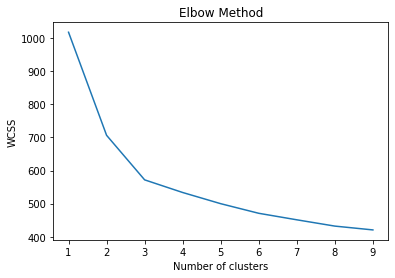

In [76]:
plt.plot(range(1,10),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.jpg')

In [65]:
#select 3 as the optimal clusters
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)

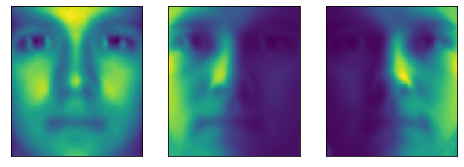

In [74]:
#visualize the centroid in each cluster
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(3,192,168)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center)
fig.savefig('center.jpg')

**Thank you for reading!!**